XRF detection limits
========

In [1]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types

components = {}
k = compoundfromname.compoundfromname("linseed oil")
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Al2O3",4.02)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("SiO2",2.66)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCO3",2.71)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("Fe3(PO4)2(H2O)8",2.65)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("PbSO4",2.65)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CaCl2",2.15)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("CeO2",7.22)
components[k] = 1
k = compoundfromformula.CompoundFromFormula("TiO2",7.22)

mix = mixture.Mixture(components.keys(),components.values(),\
                      types.fraction.mass,name="My mixture")

print(mix)

12.50 wt% Al2O3 + 12.50 wt% CaCl2 + 12.50 wt% SiO2 + 12.50 wt% CaCO3 + 12.50 wt% linseed oil + 12.50 wt% PbSO4 + 12.50 wt% CeO2 + 12.50 wt% Fe3(PO4)2(H2O)8


In [2]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries
from spectrocrunch.sources import xray as xraysources

source = xraysources.factory("synchrotron")
detector = xrfdetectors.factory("leia")
geometry = xrfgeometries.factory("sxm120",detectorposition=-20.,detector=detector,source=source)

1.1939658619600233


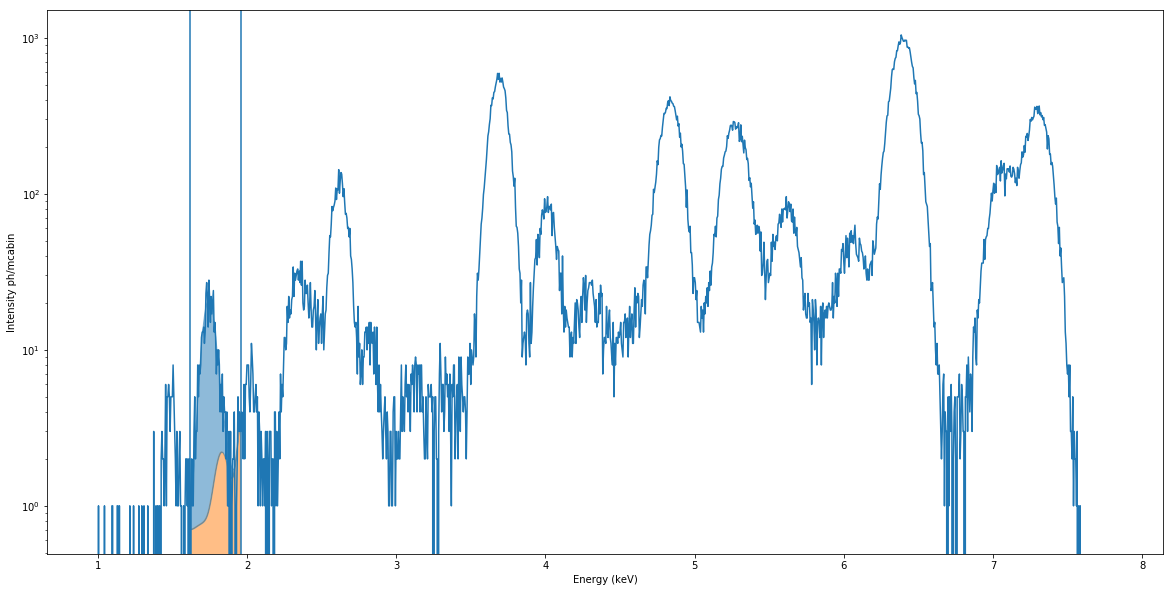

0.3362786074302331


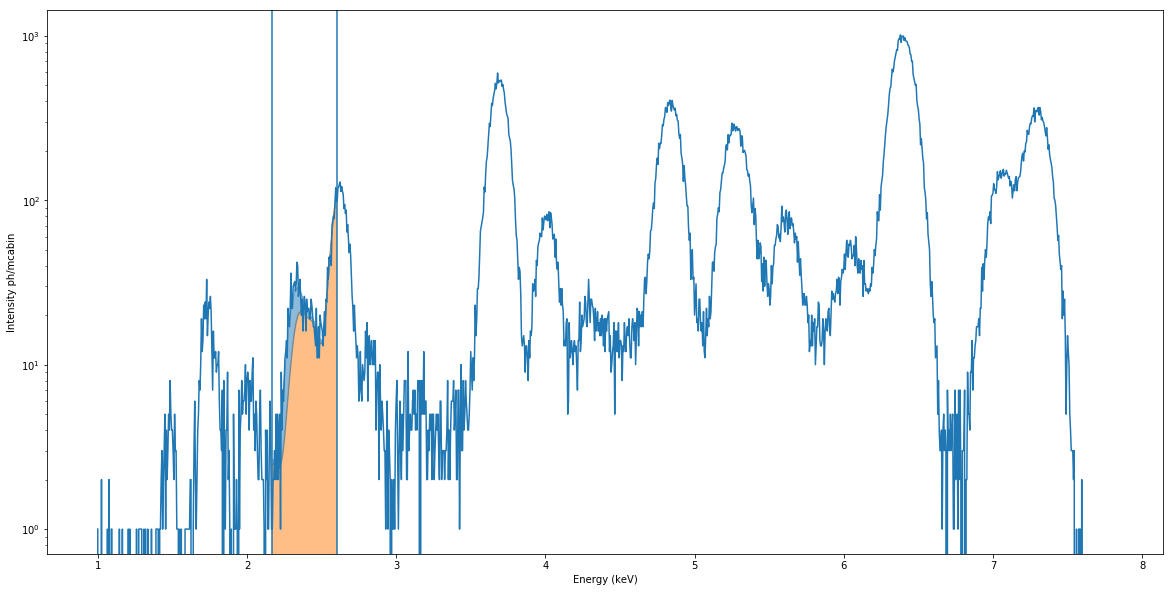

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

energy = 7.3 # keV
flux = 1e10 # ph/s
time = 0.1 # s
thickness = 10 # micron

sample = multilayer.Multilayer(material=mix,thickness=thickness*1e-4,geometry = geometry)

# Background
detector.bstail = True
bkgfluxmax = 100
backfunc = lambda x: np.clip(bkgfluxmax*time-5*(x-5)**2,0,None)

def plotspectrum(sample,lineselect,energy=energy,flux=flux,time=time,backfunc=backfunc):
    spectrum = sample.xrayspectrum(energy,emin=1,emax=energy+0.5)

    energies,profiles,ylabel,lines = spectrum.groupspectra(histogram=True,fluxtime=flux*time)
    bkg = backfunc(energies)
    sumspectrum = profiles.sum(axis=-1)+bkg

    elspectrum = sum(y for line,y in zip(lines,profiles.T) if line.startswith(lineselect))
    elspectrum += bkg

    plt.plot(energies,sumspectrum,label="sum")
    plt.plot(energies,bkg,label="bkg")
    plt.plot(energies,elspectrum,label=lineselect)

    plt.gca().set_yscale('log', basey=10)
    plt.ylim((1,np.max(sumspectrum)))
    plt.ylabel(ylabel)
    plt.xlabel("Energy (keV)")
    plt.legend(loc="best")

def setmassfraction(mix,comp,value):
    # rebalance others
    w = mix.weightfractions()
    w2 = dict(w)
    w2.pop(comp)
    v2 = np.asarray(w2.values())
    v2 *= (1-value)/v2.sum()
    # update fractions
    w.update((k,v) for k,v in zip(w2.keys(),v2))
    w[comp] = value
    mix.change_fractions(w,types.fraction.mass)

def detectionlimits(sample,lineselect,energy=energy,flux=flux,time=time,backfunc=backfunc):
    spectrum = sample.xrayspectrum(energy,emin=1,emax=energy+0.5)
    linevalid = lambda line: line.startswith(lineselect)
    ret = spectrum.detectionlimits(linevalid,fluxtime=flux*time,histogram=True,backfunc=backfunc,plot=True)

    plt.gca().set_yscale('log', basey=10)
    #plt.ylim((1,np.max(sumspectrum)))
    return ret

for peaksel in ["Si-K","S-K"]:
    #setmassfraction(mix,"SiO2",0.2)
    plt.figure(figsize=(20,10))
    print detectionlimits(sample,peaksel)
    #plt.figure()
    #plotspectrum(sample,peaksel)
    plt.show()